https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

In [23]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
import numpy as np
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

In [120]:
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-5, 5]
    X1 = 2*rand(n) - 1
    #print(X1)
    # generate outputs X^3
    #X2 = np.sin(X1*2*1*np.pi)
    X2 = X1 * X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y

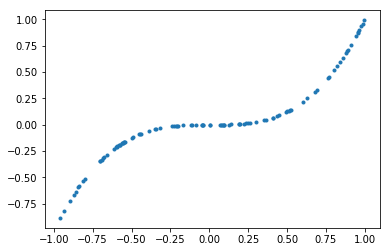

In [122]:
data, labels = generate_real_samples(100)
plt.plot(data[:,0],data[:,1],'.')

(-1, 1)

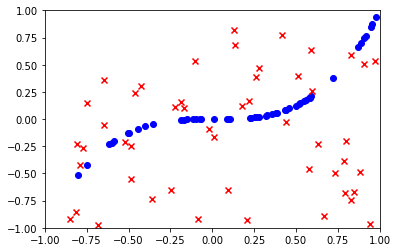

In [123]:
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# generate n fake samples with class labels
def generate_fake_samples(n):
	# generate inputs in [-5, 5]
	X1 = 2*rand(n) - 1
	# generate outputs in [-1, 1]
	X2 = -1 + rand(n) * 2
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = zeros((n, 1))
	return X, y

# train the discriminator model
def train_discriminator(model, n_epochs=1000, n_batch=128):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
	return model

# define the discriminator model
model = define_discriminator()
# fit the model
trained_model = train_discriminator(model)
        
data_real, labels = generate_real_samples(50)
data_fake, labels = generate_fake_samples(50)
plt.scatter(data_real[:,0],data_real[:,1],color='b')
plt.scatter(data_fake[:,0],data_fake[:,1],color='r',marker='x')
plt.xlim(-1,1)
plt.ylim(-1,1)

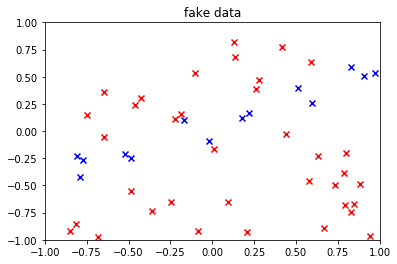

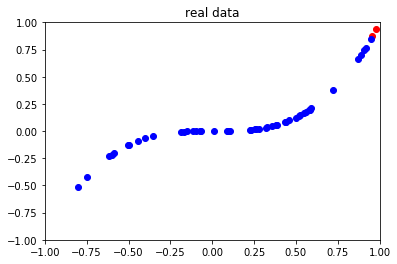

In [124]:
pred_fake = trained_model.predict(data_fake)
pred_real = trained_model.predict(data_real)
for i in np.arange(0,data_fake.shape[0]):
    if pred_fake[i]<0.5:
        c = 'r'
    if pred_fake[i]>=0.5:
        c = 'b'
    plt.scatter(data_fake[i,0],data_fake[i,1],color=c,marker='x')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title('fake data')
plt.show()

for i in np.arange(0,data_real.shape[0]):
    if pred_real[i]<0.5:
        c = 'r'
    if pred_real[i]>=0.5:
        c = 'b'
    plt.scatter(data_real[i,0],data_real[i,1],color=c)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title('real data')
plt.show()

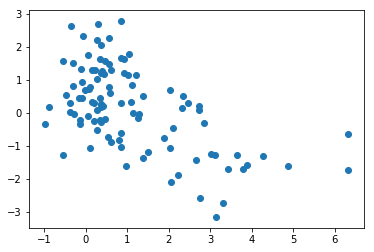

In [125]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# plot the results
	pyplot.scatter(X[:, 0], X[:, 1])
	pyplot.show()
    
# size of the latent space
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)

1999 0.51 0.53


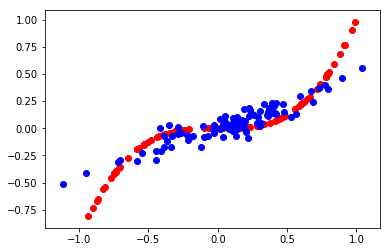

3999 0.21 0.85


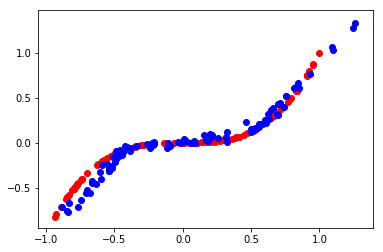

5999 0.6 0.41


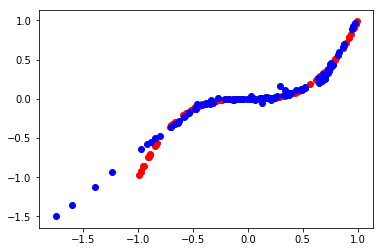

7999 0.59 0.58


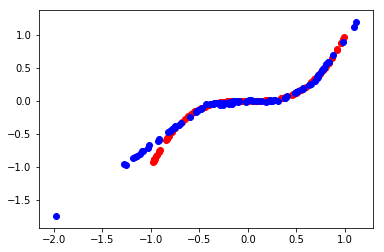

9999 0.37 0.62


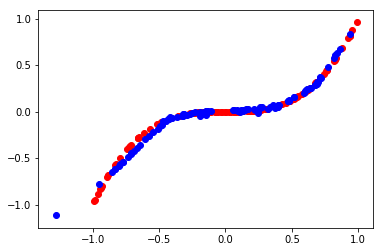

In [126]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)